<a href="https://colab.research.google.com/github/ellerybledsoe/DataScienceGuidedCapstone/blob/master/Austin_Restaurant_Inspections_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#from google.colab import files

In [3]:
%ls

austin_restaurant_inspections_full_dataset_03.csv
austin_restaurant_inspections_X_test.csv
austin_restaurant_inspections_X_test_scaled.csv
austin_restaurant_inspections_X_train.csv
austin_restaurant_inspections_X_train_scaled.csv
austin_restaurant_inspections_y_test.csv
austin_restaurant_inspections_y_test_scaled.csv
austin_restaurant_inspections_y_train.csv
austin_restaurant_inspections_y_train_scaled.csv
sample_data/


## Reading in the data

In [4]:
full = pd.read_csv('/content/austin_restaurant_inspections_full_dataset_03.csv')
X_train_scaled = pd.read_csv('/content/austin_restaurant_inspections_X_train_scaled.csv')
X_test_scaled = pd.read_csv('/content/austin_restaurant_inspections_X_test_scaled.csv')
y_train = pd.read_csv('/content/austin_restaurant_inspections_y_train_scaled.csv')
y_test = pd.read_csv('/content/austin_restaurant_inspections_y_test_scaled.csv')

#/content/austin_restaurant_inspections_X_test.csv

In [5]:
X_train_scaled.head()

,Unnamed: 0,review_length,review_word_count,oldest_score,newest_score,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,is_open,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,Food,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_0.0,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0,Score_LG
0,4153,0.042165,0.043746,0.800000,0.277778,0.010256,0.375,0.004975,0.000000,0.000000,0.5,0.000,1.0,1.0,1,1.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0.030303,0.0,1.0,0.0,1.0,0.055556,1,0,0.0,0,0.0,0.000000,0.0,0.0,1,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,1.0,0,0,1,0,0.933333
1,2528,0.188831,0.180803,0.533333,0.611111,0.087179,0.750,0.039801,0.046053,0.037838,0.5,0.040,1.0,1.0,1,1.0,1.0,0.178571,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0.090909,0.0,0.0,0.0,0.0,0.111111,1,0,0.0,1,0.0,0.000000,0.0,1.0,0,1.0,1.0,0.0,0.0,0,1,0.0,0.0,0,1.0,1.0,0,0,1,0,0.644444
2,5064,0.000000,0.000000,0.866667,0.805556,0.000000,0.500,0.000000,0.000000,0.000000,0.5,0.000,1.0,1.0,0,0.0,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0,0,0.0,1,1.0,0.000000,1.0,0.0,0,0.0,1.0,0.0,1.0,0,1,0.0,1.0,0,1.0,0.0,0,0,1,0,0.844444
3,4135,0.018644,0.016990,1.000000,0.722222,0.005128,0.750,0.000000,0.006579,0.000000,0.0,0.000,1.0,1.0,1,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.000000,0.0,0.0,0.0,1.0,0.000000,0,0,0.0,0,0.0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,1,0,0,0,1.000000
4,723,0.279299,0.275184,0.822222,0.750000,0.179487,0.750,0.054726,0.118421,0.027027,0.5,0.024,1.0,1.0,1,1.0,1.0,0.250000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.121212,1.0,0.0,0.0,0.0,0.222222,0,1,1.0,0,0.0,0.083333,1.0,0.0,0,1.0,1.0,1.0,0.0,1,0,0.0,0.0,0,0.0,0.0,0,0,1,0,0.822222


In [6]:
y_train.pass_fail_flag.value_counts(normalize=True)

0    0.991414
1    0.008586
Name: pass_fail_flag, dtype: float64

In [7]:
full.letter_grade.value_counts(normalize=True)

A    0.582074
B    0.315762
C    0.093922
F    0.008242
Name: letter_grade, dtype: float64

In [8]:
y_train.drop(columns=['Unnamed: 0'], inplace = True)
X_train_scaled.drop(columns=['Unnamed: 0','Score_LG','oldest_score','newest_score','is_open','RestaurantsPriceRange_0.0','Food'], inplace = True)
y_test.drop(columns=['Unnamed: 0'], inplace = True)
X_test_scaled.drop(columns=['Unnamed: 0','Score_LG','oldest_score','newest_score','is_open','RestaurantsPriceRange_0.0','Food'], inplace = True)

In [9]:
print(X_train_scaled.shape)
print(y_train.shape)
print(y_test.shape)

train_scaled = pd.concat([y_train,X_train_scaled], axis=1)
test_scaled = pd.concat([y_test,X_test_scaled], axis=1)

print(train_scaled.shape)
print(test_scaled.shape)

(4659, 50)
(4659, 1)
(1165, 1)
(4659, 51)
(1165, 51)


In [10]:
print(train_scaled.columns)

Index(['pass_fail_flag', 'review_length', 'review_word_count', 'reviews_count',
       'stars', 'useful_sum', 'stars_5.0_sum', 'cool_sum',
       'RestaurantsPriceRange2', 'funny_sum', 'Restaurants',
       'BusinessAcceptsCreditCards', 'Smoking_0', 'RestaurantsTakeOut',
       'stars_4.0_sum', 'RestaurantsGoodForGroups', 'GoodForKids',
       'BikeParking', 'lot', 'HasTV', 'RestaurantsDelivery', 'casual',
       'NoiseLevel_u'average'', 'stars_1.0_sum', 'OutdoorSeating', 'lunch',
       'Caters', 'stars_3.0_sum', 'RestaurantsAttire_'casual'',
       'RestaurantsAttire_u'casual'', 'dinner', 'WiFi_u'free'',
       'WheelchairAccessible', 'stars_2.0_sum', 'HappyHour', 'classy',
       'Alcohol_u'none'', 'RestaurantsTableService', 'street',
       'RestaurantsReservations', 'Bars', 'WiFi_u'no'', 'Alcohol_u'full_bar'',
       'Mexican', 'Nightlife', 'NoiseLevel_0', 'DogsAllowed',
       'Breakfast & Brunch', 'RestaurantsPriceRange_1.0',
       'RestaurantsPriceRange_2.0', 'RestaurantsPrice

In [11]:
train_scaled.pass_fail_flag.value_counts(normalize=True)

0    0.991414
1    0.008586
Name: pass_fail_flag, dtype: float64

In [12]:
train_scaled.head(1)

,pass_fail_flag,review_length,review_word_count,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0
0,0,0.042165,0.043746,0.010256,0.375,0.004975,0.0,0.0,0.5,0.0,1.0,1.0,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0.030303,0.0,1.0,0.0,0.055556,1,0,0.0,0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,1.0,0,1,0


In [13]:
pass_train_data = train_scaled[train_scaled.pass_fail_flag == 0].iloc[:,1:]
fail_train_data = train_scaled[train_scaled.pass_fail_flag == 1].iloc[:,1:]

In [14]:
fail_train_data.head()

,review_length,review_word_count,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0
9,0.039815,0.039331,0.046154,0.625,0.024876,0.019737,0.0,0.50,0.000,1.0,1.0,1,1.0,0.035714,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1,0.121212,0.0,1.0,1.0,0.055556,0,1,1.0,1,0.0,0.000000,0.0,0.0,1,0.0,0.0,1.0,0.0,0,0,0.0,0.0,0,0.0,0.0,0,1,0
164,0.018076,0.017993,0.015385,0.625,0.014925,0.006579,0.0,0.25,0.008,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1,0.030303,1.0,1.0,1.0,0.000000,1,0,0.0,1,0.0,0.041667,1.0,0.0,0,0.0,1.0,1.0,1.0,0,1,1.0,1.0,0,0.0,0.0,1,0,0
296,0.010560,0.010702,0.010256,0.250,0.004975,0.000000,0.0,0.25,0.016,1.0,1.0,1,1.0,0.000000,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0,0.030303,0.0,0.0,0.0,0.000000,0,1,0.0,0,0.0,0.041667,0.0,0.0,1,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,1,0,0
408,0.000000,0.000000,0.000000,0.500,0.000000,0.000000,0.0,0.50,0.000,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.000000,1.0,1.0,0.0,0.000000,1,0,1.0,0,1.0,0.000000,1.0,0.0,0,0.0,0.0,1.0,1.0,1,0,0.0,0.0,0,0.0,0.0,0,1,0
482,0.000000,0.000000,0.000000,0.625,0.000000,0.000000,0.0,0.50,0.000,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0.000000,0.0,1.0,1.0,0.000000,0,1,1.0,1,0.0,0.000000,1.0,1.0,0,0.0,1.0,0.0,1.0,0,0,0.0,1.0,0,0.0,0.0,0,1,0


In [15]:
pass_test_data = test_scaled[test_scaled.pass_fail_flag == 0].iloc[:,1:].reset_index(drop=True)
fail_test_data = test_scaled[test_scaled.pass_fail_flag == 1].iloc[:,1:].reset_index(drop=True)

In [16]:
pass_train_data.shape

(4619, 50)

## Building an AutoEncoder

In [17]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dense(25, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='sigmoid'))

#https://www.youtube.com/watch?v=S31E-ftRfQI&list=PLbxRL2wtmn7rENj4iA3FC5VE4LNvIweqs&index=2

In [18]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Dense(25,activation='relu'),
      tf.keras.layers.Dense(12,activation='relu'),
      tf.keras.layers.Dense(6,activation='relu')])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(12,activation='relu'),
      tf.keras.layers.Dense(25,activation='relu'),
      tf.keras.layers.Dense(50,activation='sigmoid')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# https://www.youtube.com/watch?v=S31E-ftRfQI&list=PLbxRL2wtmn7rENj4iA3FC5VE4LNvIweqs&index=2

In [19]:
model = AutoEncoder()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

model.compile(optimizer='adam', loss='mean_squared_error')

#https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

In [20]:
ae = model.fit(pass_train_data, pass_train_data,
               epochs = 40,
               batch_size = 20,
               validation_data = (train_scaled.iloc[:,1:], train_scaled.iloc[:,1:]),
               shuffle = True,
               callbacks = [early_stop])

Epoch 1/40
231/231 [==============================] - 2s 3ms/step - loss: 0.1432 - val_loss: 0.1094
Epoch 2/40
231/231 [==============================] - 0s 2ms/step - loss: 0.0999 - val_loss: 0.0933
Epoch 3/40
231/231 [==============================] - 1s 3ms/step - loss: 0.0880 - val_loss: 0.0825
Epoch 4/40
231/231 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0775
Epoch 5/40
231/231 [==============================] - 1s 3ms/step - loss: 0.0756 - val_loss: 0.0742
Epoch 6/40
231/231 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0728
Epoch 7/40
231/231 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0723
Epoch 8/40
231/231 [==============================] - 0s 2ms/step - loss: 0.0717 - val_loss: 0.0712
Epoch 9/40
231/231 [==============================] - 1s 3ms/step - loss: 0.0710 - val_loss: 0.0704
Epoch 10/40
231/231 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0696

In [21]:
pass_test_data.head()

,review_length,review_word_count,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0
0,0.021689,0.020042,0.008065,0.571429,0.000000,0.005348,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.022222,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,0.000000,1.0,1.0,0.0,0.0,1,0,0.0,0,0.0,0.0,0.0,0.0,1,1.0,1.0,0.0,1.0,0,0,0.0,1.0,0,0.0,1.0,1,0,0
1,0.030766,0.029896,0.008065,0.428571,0.000000,0.000000,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.022222,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0.035714,0.0,0.0,1.0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1,0.0,0.0,1,0,0
2,0.044780,0.041587,0.020161,0.714286,0.033898,0.021390,0.029557,0.50,0.034247,1.0,1.0,1,1.0,0.022222,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1,0.000000,1.0,1.0,1.0,0.0,0,1,1.0,0,0.0,0.0,0.0,0.0,0,1.0,0.0,1.0,0.0,0,1,0.0,0.0,0,1.0,0.0,0,1,0
3,0.008249,0.007516,0.004032,0.571429,0.000000,0.005348,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1,0.000000,1.0,1.0,1.0,0.0,1,0,0.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0,0,1.0,0.0,0,0.0,0.0,1,0,0
4,0.000000,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,1,0,0


In [22]:
pass_test_data.dtypes

review_length                  float64
review_word_count              float64
reviews_count                  float64
stars                          float64
useful_sum                     float64
stars_5.0_sum                  float64
cool_sum                       float64
RestaurantsPriceRange2         float64
funny_sum                      float64
Restaurants                    float64
BusinessAcceptsCreditCards     float64
Smoking_0                        int64
RestaurantsTakeOut             float64
stars_4.0_sum                  float64
RestaurantsGoodForGroups       float64
GoodForKids                    float64
BikeParking                    float64
lot                            float64
HasTV                          float64
RestaurantsDelivery            float64
casual                         float64
NoiseLevel_u'average'            int64
stars_1.0_sum                  float64
OutdoorSeating                 float64
lunch                          float64
Caters                   

In [23]:
#pass_test_data[pass_test_data.isna().any(axis=1)]
#pass_train_data.to_numpy()

In [24]:
encoder_out = model.encoder(pass_train_data.to_numpy())
decoder_out = model.decoder(encoder_out)

In [25]:
print(encoder_out.shape)
print(decoder_out.shape)

(4619, 6)
(4619, 50)


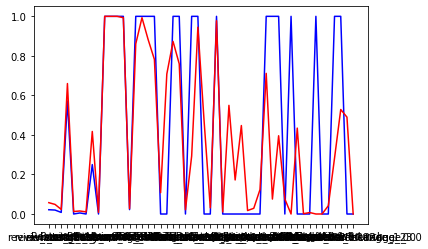

In [26]:
plt.plot(pass_test_data.iloc[0],'b')
plt.plot(decoder_out[0],'r')

In [27]:
encoder_out = model.encoder(fail_train_data.to_numpy())
decoder_out = model.decoder(encoder_out)

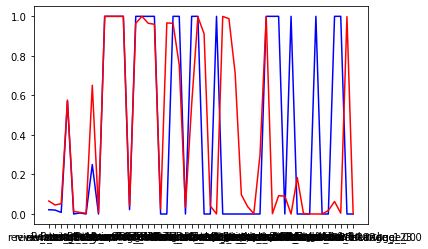

In [28]:
plt.plot(pass_test_data.iloc[0],'b')
plt.plot(decoder_out[0],'r')

(array([  5.,  32.,  45.,  81.,  56., 110.,  99., 105.,  80.,  96.,  83.,
         75.,  49.,  46.,  45.,  32.,  36.,  18.,  16.,  16.,  12.,   4.,
          5.,   6.,   1.,   2.,   1.,   0.,   0.,   1.]),
 array([0.00337243, 0.00982532, 0.01627821, 0.02273111, 0.029184  ,
        0.0356369 , 0.04208979, 0.04854268, 0.05499558, 0.06144847,
        0.06790137, 0.07435426, 0.08080715, 0.08726005, 0.09371294,
        0.10016584, 0.10661873, 0.11307162, 0.11952452, 0.12597741,
        0.13243031, 0.1388832 , 0.14533609, 0.15178899, 0.15824188,
        0.16469478, 0.17114767, 0.17760056, 0.18405346, 0.19050635,
        0.19695925]),
 <a list of 30 Patch objects>)

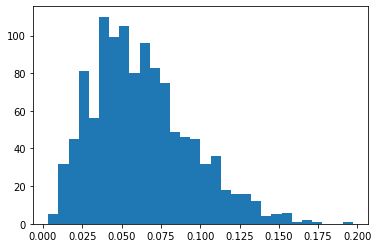

In [29]:
reconstruct = model.predict(pass_test_data)
train_loss = tf.keras.losses.mean_squared_error(reconstruct, pass_test_data)

plt.hist(train_loss, bins=30)

In [30]:
print(np.mean(train_loss))
print(np.std(train_loss))


0.06296016974951373
0.031237290980021738


In [31]:
_2sigma_boundary = np.mean(train_loss) + 2*np.std(train_loss)
_2sigma_boundary

0.1254347517095572

(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 2., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.04479208, 0.04777791, 0.05076373, 0.05374956, 0.05673539,
        0.05972121, 0.06270704, 0.06569287, 0.0686787 , 0.07166452,
        0.07465035, 0.07763618, 0.08062201, 0.08360783, 0.08659366,
        0.08957949, 0.09256532, 0.09555114, 0.09853697, 0.1015228 ,
        0.10450863, 0.10749445, 0.11048028, 0.11346611, 0.11645194,
        0.11943776, 0.12242359, 0.12540942, 0.12839525, 0.13138107,
        0.1343669 ]),
 <a list of 30 Patch objects>)

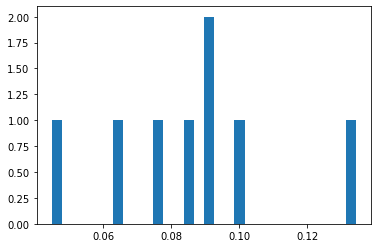

In [32]:
reconstruct_f = model.predict(fail_test_data)
train_loss_f = tf.keras.losses.mean_squared_error(reconstruct_f, fail_test_data)

plt.hist(train_loss_f, bins = 30)

In [33]:
print(np.mean(train_loss_f))
print(np.std(train_loss_f))

0.08567943759492923
0.024364550147084916


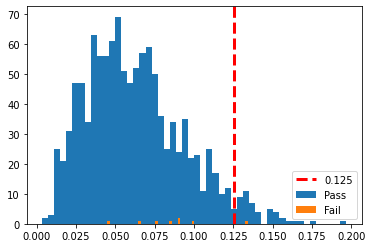

In [34]:
plt.hist(train_loss,bins=50, label = 'Pass')
plt.hist(train_loss_f,bins=50, label = 'Fail')

plt.axvline(_2sigma_boundary, color = 'r', linewidth =3, linestyle='dashed', label ='{:0.3f}'.format(_2sigma_boundary))

plt.legend(loc='lower right')
plt.show()

In [35]:
preds = tf.math.greater(train_loss_f, _2sigma_boundary)

In [36]:
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [37]:
preds.shape

TensorShape([8])

## Building an Isolation Forest

In [38]:
X_train = pd.read_csv('/content/austin_restaurant_inspections_X_train.csv')
X_test = pd.read_csv('/content/austin_restaurant_inspections_X_test.csv')
y_train = pd.read_csv('/content/austin_restaurant_inspections_y_train.csv')
y_test = pd.read_csv('/content/austin_restaurant_inspections_y_test.csv')

In [39]:
X_train.head()

,Unnamed: 0,review_length,review_word_count,Score,oldest_score,newest_score,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,is_open,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,Food,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_0.0,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0
0,4153,1669.0,327.0,97.0,91.0,74.0,2.0,2.5,1.0,0.0,0.0,2,0.0,1.0,1.0,1,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0,0.0,1.0,0.0,1.0,1.0,1,0,0.0,0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,1.0,0,0,1,0
1,2528,7474.5,1351.5,84.0,79.0,86.0,17.0,4.0,8.0,7.0,7.0,2,5.0,1.0,1.0,1,1.0,1.0,5.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,3.0,0.0,0.0,0.0,0.0,2.0,1,0,0.0,1,0.0,0.0,0.0,1.0,0,1.0,1.0,0.0,0.0,0,1,0.0,0.0,0,1.0,1.0,0,0,1,0
2,5064,0.0,0.0,93.0,94.0,93.0,0.0,3.0,0.0,0.0,0.0,2,0.0,1.0,1.0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1,1.0,0.0,1.0,0.0,0,0.0,1.0,0.0,1.0,0,1,0.0,1.0,0,1.0,0.0,0,0,1,0
3,4135,738.0,127.0,100.0,100.0,90.0,1.0,4.0,0.0,1.0,0.0,0,0.0,1.0,1.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,1,0,0,0
4,723,11055.5,2057.0,92.0,92.0,91.0,35.0,4.0,11.0,18.0,5.0,2,3.0,1.0,1.0,1,1.0,1.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,4.0,1.0,0.0,0.0,0.0,4.0,0,1,1.0,0,0.0,2.0,1.0,0.0,0,1.0,1.0,1.0,0.0,1,0,0.0,0.0,0,0.0,0.0,0,0,1,0


In [40]:
y_train.drop(columns=['Unnamed: 0'], inplace = True)
X_train.drop(columns=['Unnamed: 0','Score','oldest_score','newest_score','is_open','RestaurantsPriceRange_0.0','Food'], inplace = True)
y_test.drop(columns=['Unnamed: 0'], inplace = True)
X_test.drop(columns=['Unnamed: 0','Score','oldest_score','newest_score','is_open','RestaurantsPriceRange_0.0','Food'], inplace = True)

In [41]:
# fitting on all training data

from pylab import savefig
from sklearn.ensemble import IsolationForest

rseed = 9887

iso = IsolationForest(max_samples=100,n_estimators=10, random_state=rseed)
iso.fit(X_train)

y_pred_train = iso.predict(X_train)
y_pred_test = iso.predict(X_test)
y_pred_outliers = iso.predict(fail_test_data)

# https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

In [42]:
print("Accuracy on passes, full train:", list(y_pred_train).count(1)/y_pred_train.shape[0])
print("Accuracy on passes, full test:", list(y_pred_test).count(1)/y_pred_test.shape[0])

print("Accuracy on fails, fail_test:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Accuracy on passes, full train: 0.5338055376690277
Accuracy on passes, full test: 0.5553648068669528
Accuracy on fails, fail_test: 0.75


In [43]:
pass_test_data.head()

,review_length,review_word_count,reviews_count,stars,useful_sum,stars_5.0_sum,cool_sum,RestaurantsPriceRange2,funny_sum,Restaurants,BusinessAcceptsCreditCards,Smoking_0,RestaurantsTakeOut,stars_4.0_sum,RestaurantsGoodForGroups,GoodForKids,BikeParking,lot,HasTV,RestaurantsDelivery,casual,NoiseLevel_u'average',stars_1.0_sum,OutdoorSeating,lunch,Caters,stars_3.0_sum,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',dinner,WiFi_u'free',WheelchairAccessible,stars_2.0_sum,HappyHour,classy,Alcohol_u'none',RestaurantsTableService,street,RestaurantsReservations,Bars,WiFi_u'no',Alcohol_u'full_bar',Mexican,Nightlife,NoiseLevel_0,DogsAllowed,Breakfast & Brunch,RestaurantsPriceRange_1.0,RestaurantsPriceRange_2.0,RestaurantsPriceRange_3.0
0,0.021689,0.020042,0.008065,0.571429,0.000000,0.005348,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.022222,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,0.000000,1.0,1.0,0.0,0.0,1,0,0.0,0,0.0,0.0,0.0,0.0,1,1.0,1.0,0.0,1.0,0,0,0.0,1.0,0,0.0,1.0,1,0,0
1,0.030766,0.029896,0.008065,0.428571,0.000000,0.000000,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.022222,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0.035714,0.0,0.0,1.0,0.0,0,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1,0.0,0.0,1,0,0
2,0.044780,0.041587,0.020161,0.714286,0.033898,0.021390,0.029557,0.50,0.034247,1.0,1.0,1,1.0,0.022222,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1,0.000000,1.0,1.0,1.0,0.0,0,1,1.0,0,0.0,0.0,0.0,0.0,0,1.0,0.0,1.0,0.0,0,1,0.0,0.0,0,1.0,0.0,0,1,0
3,0.008249,0.007516,0.004032,0.571429,0.000000,0.005348,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1,0.000000,1.0,1.0,1.0,0.0,1,0,0.0,0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0,0,1.0,0.0,0,0.0,0.0,1,0,0
4,0.000000,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.25,0.000000,1.0,1.0,1,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.000000,0.0,0.0,0.0,0.0,1,0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0.0,0.0,1,0,0


In [44]:
pass_train_y_val = test_scaled[train_scaled.pass_fail_flag == 0].iloc[:,0:1].reset_index(drop=True)
fail_train_y_val = test_scaled[train_scaled.pass_fail_flag == 1].iloc[:,0:1].reset_index(drop=True)
pass_test_y_val = test_scaled[test_scaled.pass_fail_flag == 0].iloc[:,0:1].reset_index(drop=True)
fail_test_y_val = test_scaled[test_scaled.pass_fail_flag == 1].iloc[:,0:1].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [45]:
fail_test_y_val.head()

,pass_fail_flag
0,1
1,1
2,1
3,1
4,1


In [46]:
# fitting on all 'passing' training data
iso = IsolationForest(max_samples=100,n_estimators=20, random_state=rseed)
iso.fit(pass_train_data)


y_pred_train = iso.predict(pass_train_data)
y_pred_test = iso.predict(pass_test_data)
y_pred_outliers = iso.predict(fail_test_data)

In [47]:
print("Accuracy on passes, pass_train:", list(y_pred_train).count(1)/y_pred_train.shape[0])
print("Accuracy on passes, pass_test:", list(y_pred_test).count(1)/y_pred_test.shape[0])

print("Accuracy on fails, fail_test:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Accuracy on passes, pass_train: 0.4762935700368045
Accuracy on passes, pass_test: 0.46672428694900603
Accuracy on fails, fail_test: 0.875


In [48]:
print(y_pred_outliers)

[-1 -1 -1 -1 -1 -1 -1  1]


In [49]:
y = pd.concat([y_train,y_test]).reset_index(drop=True)
y_pred = iso.predict(pd.concat([X_train,X_test]).reset_index(drop=True))

In [50]:
# # plot the line, the samples, and the nearest vectors to the plane
# xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
# Z = iso.decision_function(np.c_[fail_test_y_val, y_pred_outliers])
# Z = Z.reshape(xx.shape)

# plt.title("IsolationForest")
# plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

# b1 = plt.scatter(pass_train_data[:, 0], pass_train_data[:, 1], c='white',
#                  s=20, edgecolor='k')
# b2 = plt.scatter(pass_test_data[:, 0], pass_test_data[:, 1], c='green',
#                  s=20, edgecolor='k')
# c = plt.scatter(fail_test_data[:, 0], fail_test_data[:, 1], c='red',
#                 s=20, edgecolor='k')
# plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([b1, b2, c],
#            ["training observations",
#             "new regular observations", "new abnormal observations"],
#            loc="upper left")
# plt.show()

     |████████████████████████████████| 356 kB 13.7 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491643 sha256=c7f842684e285abe21060d782dc6c1797cfdd8edf9d5d6908258798cf2326ba0
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


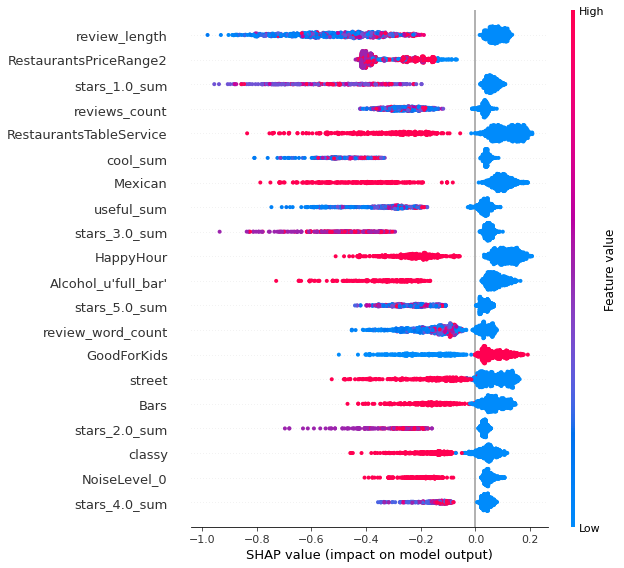

In [51]:
!pip install shap
import shap

# Create shap values and plot them
X_explain = X_test
shap_values = shap.TreeExplainer(iso).shap_values(X_explain)
shap.summary_plot(shap_values, X_explain)

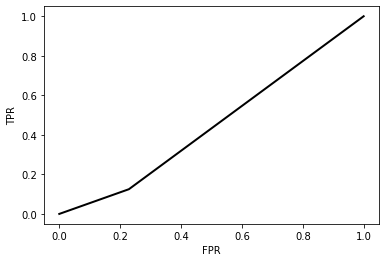

In [53]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y,y_pred)
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [54]:
iso.decision_function(pd.concat([X_train,X_test]).reset_index(drop=True))

array([-0.13041156, -0.16570883, -0.06434713, ..., -0.09015123,
       -0.03715004, -0.04965052])

In [55]:
iso.score_samples(pd.concat([X_train,X_test]).reset_index(drop=True))

array([-0.63041156, -0.66570883, -0.56434713, ..., -0.59015123,
       -0.53715004, -0.54965052])

In [56]:
y['decision_func'] = iso.decision_function(pd.concat([X_train,X_test]).reset_index(drop=True)).tolist()
y['score_samples'] = iso.decision_function(pd.concat([X_train,X_test]).reset_index(drop=True)).tolist()

In [58]:
y.head()

,pass_fail_flag,decision_func,score_samples
0,0,-0.130412,-0.130412
1,0,-0.165709,-0.165709
2,0,-0.064347,-0.064347
3,0,-0.065607,-0.065607
4,0,-0.161731,-0.161731


In [59]:
y.to_csv('iso_results')

In [60]:
iso.get_params()

{'behaviour': 'deprecated',
 'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 100,
 'n_estimators': 20,
 'n_jobs': None,
 'random_state': 9887,
 'verbose': 0,
 'warm_start': False}

In [68]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.array(y['pass_fail_flag']), y_pred)

In [71]:
#y_pred

In [72]:
#np.array(y['pass_fail_flag'])

In [73]:
#cm